<a href="https://colab.research.google.com/github/leobii/AI-in-Digital-Signal-Analysis-and-Applications/blob/main/YuChen_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install tensorflow==1.14.0
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import tensorflow as tf      # Version 1.0.0 (some previous versions are used in past commits)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn import metrics
import random
from random import randint
import time
import os, sys
tf.reset_default_graph()


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [ ]:
# 調整使用的 gpu ， 只讓 CUDA 程式使用第一張 GPU 卡

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf

# 定当前程序只使用下标为0、1的两块显卡（GPU:0 和 GPU:1），可以使用以下代码：
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

if gpus:
    try:
      #tf.config.experimental.set_virtual_devices('GPU')
      for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[]


In [ ]:
#---------------------------------------#
#---------- Preparing dataset ----------#
#---------------------------------------#

# Useful Constants
# Output classes to learn how to classify
LABELS = [   
    "Group1_Person_0", 
    "Group2_Person_1",
    "Group3_Person_2",  
    "Group4_Person_3",
    "Group5_Person_4",
    "Group6_Person_5",
    "Group7_Person_6",
    "Group8_Person_7",
    "Group9_Person_8",
    "Group10_Person_9",
    "Group11_Person_10",
    "Group12_Person_11",
] 

# 當前工作目錄
base_path = os.path.abspath(os.getcwd())
print(base_path)
# DATASET_PATH = base_path + "/data/walk_poses/"

X_train_path = base_path + "/drive/MyDrive/Colab Notebooks/download/new_rnn_pose_20211215/X_train.txt"

# Load the networks inputs
def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps) 
    X_ = np.array(np.array_split(X_,blocks))#np.split 把一個數組從左到右按顺序切分 
    return X_ 



# Load the networks outputs
def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()   
    # for 0-based indexing 
    return y_


/content


In [ ]:
#------------------------------------#
#---------- Set Parameters ----------#
#------------------------------------#

n_steps = 55   # 32 timesteps per series
n_hidden = 30  # Hidden layer num of features
n_classes = 12

X_train_all = load_X(X_train_path)

y_train_all = []
for i in range(12):
    y = np.ones(12*2)*i
    if i == 5:
         y = np.ones(11*2)*i
    y_train_all.extend(y)
    
print(len(X_train_all)) 
print(len(y_train_all))


286
286


In [ ]:
li = []
X_train = []
y_train = []
X_test = []
y_test = []

# 取得最常見到為零的數目
all_Count = []
for i in range(len(X_train_all)):
    x = X_train_all[i]
    zero_count = np.size( np.where(x==0))
    #print([i," ",zero_count])
    all_Count.append(zero_count)
a = np.sort(all_Count)
xzero_max = np.mean(a[1 - round(len(a)*0.2):len(a)])
print(xzero_max)
print(len(X_train_all))

817.7142857142857
286


In [ ]:
for i in range(len(X_train_all)):
    x = X_train_all[i]
    zero_count = np.size( np.where(x==0))
    #print(zero_count)
    if zero_count <= xzero_max:
        print
        a = [X_train_all[i],y_train_all[i]]  
        li.append(a)

In [ ]:
    
random.shuffle (li)
l = round(len(li)*0.3)
test_data = li[0:l]
train_data =  li[l+1:len(li)]

for i in range(len(train_data)):
  X_train.append(train_data[i][0])
  y_train.append(train_data[i][1])
for i in range(len(test_data)):
  X_test.append(test_data[i][0])
  y_test.append(test_data[i][1])

    
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_train)
print(y_train)
print(X_test)
print(y_test)

[[[  0.   0. 510. ... 211. 504. 211.]
  [  0.   0. 516. ... 214. 510. 214.]
  [  0.   0. 521. ... 211. 513. 211.]
  ...
  [329. 188. 338. ...   0. 344. 190.]
  [323. 190. 332. ...   0. 335. 190.]
  [305. 193. 314. ...   0. 320. 196.]]

 [[296. 198. 314. ...   0. 305. 196.]
  [299. 198. 314. ...   0. 308. 196.]
  [299. 198. 314. ...   0. 308. 196.]
  ...
  [293. 159. 296. ... 157. 308. 157.]
  [296. 157. 299. ... 154. 311. 157.]
  [299. 154. 299. ... 154. 311. 154.]]

 [[530.  99. 563. ...   0. 539.  94.]
  [524.  99. 557. ...   0. 533.  97.]
  [504. 110. 539. ...   0. 513. 107.]
  ...
  [169. 193. 187. ...   0. 178. 188.]
  [169. 193. 184. ...   0. 181. 188.]
  [169. 193. 181. ...   0. 178. 188.]]

 ...

 [[519. 104. 554. ... 102. 527. 102.]
  [  0.   0. 545. ... 110. 524. 104.]
  [  0.   0. 533. ... 117. 519. 112.]
  ...
  [  0.   0. 193. ... 190. 187. 190.]
  [  0.   0. 190. ... 190. 184. 190.]
  [  0.   0. 187. ... 193. 181. 193.]]

 [[133. 177. 113. ... 175.   0.   0.]
  [145. 177.

In [ ]:
training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

#print("n_input", n_input)
#sys.exit(1)
#updated for learning-rate decay
#calculated as: decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)

decaying_learning_rate = True
learning_rate = 0.025 #used if decaying_learning_rate set to False
init_learning_rate = 0.005
decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 60000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

training_iters = training_data_count *10000  # Loop 100 times on the dataset, ie 100 epochs
batch_size = 128
display_iter = batch_size*8  # To show test set accuracy during training


In [ ]:
#----------------------------------------------------#
#---------- Utility functions for training ----------#
#----------------------------------------------------#

def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_3 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2, lstm_cell_3], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):

    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1))
    #print("_unsampled1", _unsampled)
    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        if _unsampled:
            index = random.choice(_unsampled)
            batch_s[i] = _train[index] 
            batch_labels[i] = _labels[index]
            _unsampled.remove(index)
        #print("_unsampled", _unsampled)

    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) 
    return np.eye(n_values+1)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [ ]:
#---------------------------------------#
#---------- Build the network ----------#
#---------------------------------------#

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

In [ ]:
#---------------------------------------#
#---------- Train the network ----------#
#---------------------------------------#
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
# initialize the variables.
init = tf.global_variables_initializer()
# add ops to save and restore all the variables.
#tf.compat.v1.disable_eager_execution()
saver = tf.train.Saver()
sess.run(init)

# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = list(range(0,len(X_train)))

while step * batch_size <= training_iters:
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = list(range(0,len(X_train))) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training:
     #if you have test set, uncomment below.
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        _,loss, acc = sess.run(
            [optimizer ,cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

# save the variables to disk.
save_path = saver.save(sess, base_path + "/lstm_model_01.ckpt")
print("Model saved in file: %s" % save_path)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #128:  Learning rate = 0.005000:   Batch Loss = 4.277772, Accuracy = 0.1171875
PERFORMANCE ON TEST SET:             Batch Loss = 4.1001434326171875, Accuracy = 0.09756097197532654
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 3.922793, Accuracy = 0.0859375
PERFORMANCE ON TEST SET:             Batch Loss = 3.9883804321289062, Accuracy = 0.012195121496915817
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 3.761653, Accuracy = 0.1796875
PERFORMANCE ON TEST SET:             Batch Loss = 3.86964750289917, Accuracy = 0.0731707289814949
Iter #3072:  Learning rate = 0.005000:   Batch Loss = 3.742294, Accuracy = 0.15625
PERFORMANCE ON TEST SET:             Batch Loss = 3.8413772583007812, Accuracy = 0.04878048598766327
Iter #4096:  Learning rate = 0.005000:   Batch Loss = 3.526033, Accuracy = 0.21875
PERFORMANCE ON TEST SET:             Batch Loss = 3.8700499534606934, Accuracy = 0.10975609719753265
Iter #5120:  Learning rate = 0.005000:   Batch Loss = 3.547490, Accuracy = 0.

1877
15000


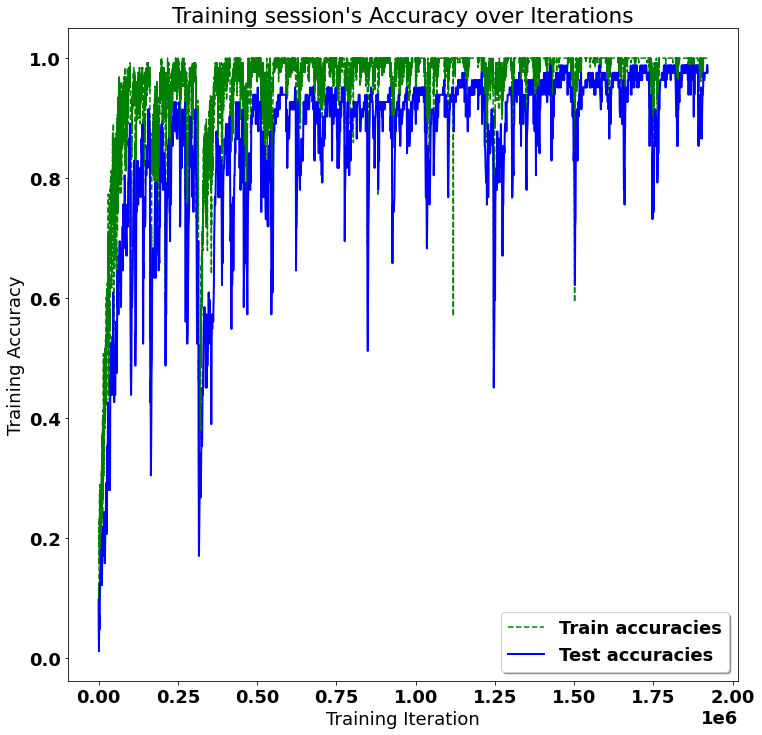

Testing Accuracy: 98.78048896789551%

Precision: 99.08536585365853%
Recall: 98.78048780487805%
f1_score: 98.79984514130855%

Confusion Matrix:
Created using test set of 82 datapoints, normalised to % of each class in the test dataset


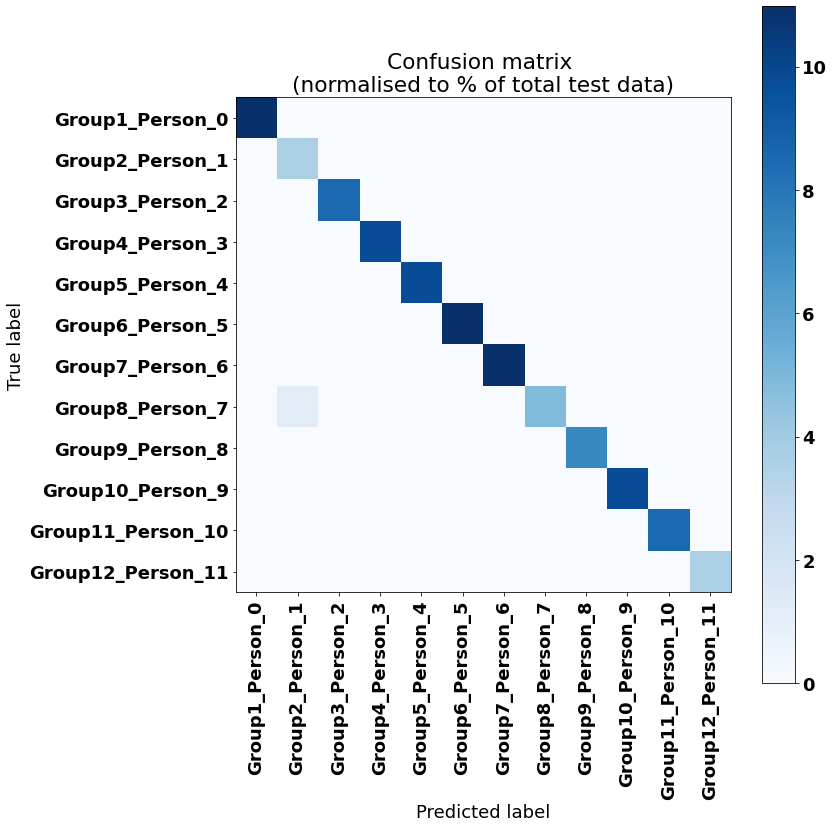

In [ ]:
#-----------------------------#
#---------- Results ----------#
#-----------------------------#
# (Inline plots: )
# %matplotlib inline

font = {
    'family' : 'DejaVu Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()